First, we need a few more packages. If you don't currently have skimage or cv2 installed, uncomment and run the lines below:

In [ ]:
#pip install scikit-image
#pip install opencv-python

In [1]:
import tensorflow as tf
import cv2
import os
import tarfile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout

# Training CNNs and Transfer Learning: Hot-Dog or Not-Dog

This problem's purpose is to build a neural network to classify images as hot dogs or not-hot dogs. This is the same problem as seen in the HBO TV show "Silicon Valley". We will be using the dataset put together by [a user on Kaggle](https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog) which contains 498 training images and 500 test images.

A simple CNN is given below. Due to the small sample size it has a very poor test set accuracy. Your task is to build a CNN that can beat this test set accuracy by a large margin (get to at least 70% test set accuracy).

We start by loading the data:

In [2]:
path_to_data =  tf.keras.utils.get_file('hotdog.tar', 'https://www.dropbox.com/s/9zx61bhlrjx135j/hotdog.tar?dl=1')
file = tarfile.open(path_to_data)
file.extractall(os.path.abspath(os.path.join(path_to_data, os.pardir)))
file.close()

49336320/49336320 [==============================] - 9s 0us/step


Let's take a look at two examples pictures:

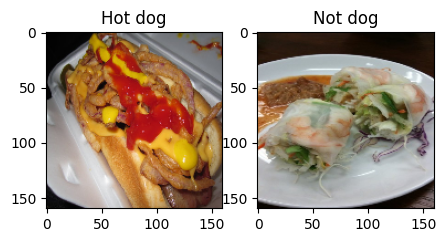

In [3]:
img_size = 160

img_arr_hotdog = cv2.imread(os.path.abspath(os.path.join(path_to_data, os.pardir,'hotdog/train/hot_dog/2417.jpg')))
img_arr_hotdog = cv2.resize(img_arr_hotdog, (img_size,img_size))[:,:,::-1]

img_arr_notdog = cv2.imread(os.path.abspath(os.path.join(path_to_data, os.pardir,'hotdog/train/not_hot_dog/197.jpg')))
img_arr_notdog = cv2.resize(img_arr_notdog, (img_size,img_size))[:,:,::-1]

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(img_arr_hotdog)
plt.title("Hot dog"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(img_arr_notdog)
plt.title("Not dog"); plt.grid(False)

Instead of loading all the data in advance, we create a data pipeline using an `ImageDataGenerator`. The generator will load in the data files as needed and perform two transformations:
- Rescaling pixels to be between [0, 1]
- Resizing images to be in `img_size`x`img_size` (160x160)

During training for each batch, the images are read from disk on the fly, loaded into memory and then the transformations are applied. Hence, we save on memory, which is one advantage of using the `ImageDataGenerator` instead of the specific augmentation layers (even though there are ways to also load from disk directly, but this goes beyond the scope here).

In [4]:
train_data_dir = os.path.abspath(os.path.join(path_to_data, os.pardir,'hotdog/train'))
test_data_dir = os.path.abspath(os.path.join(path_to_data, os.pardir,'hotdog/test'))
batch_size = 128

train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Data parameters (DO NOT MODIFY)
num_train_samples = 498
num_test_samples = 500

# Data generators (DO NOT MODIFY)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Defining and running an initial model

We define a starting model, which you will need to improve upon.

In [6]:
model1 = tf.keras.Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(img_size,img_size,3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 79, 79, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 77, 77, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 38, 38, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 18, 18, 64)       

When training the model, there is a small detail to consider: since we generate data on the fly, the training process doesn't know the total number of data points. Normally, in each epoch, we would take as many steps as needed to get through the whole dataset, given our batch_size. Hence, we have "training samples" / "batch size" as the number of steps per epoch. Here, we have to manually define that number of steps instead (and we do it in exactly this way, for consistency of the meaning of "epoch").

Also, we should split the data into training and validation. We will omit this here because the training data set is relatively small. However, if you tune hyperparameters, make sure to do such a split!

In [7]:
model1.compile(loss='binary_crossentropy',
              metrics=['accuracy'], 
              optimizer='rmsprop')
model1.fit(train_generator,
            steps_per_epoch=num_train_samples // batch_size,
            epochs=20)


Epoch 1/20


3/3 [==============================] - 3s 571ms/step - loss: 2.3281 - accuracy: 0.4649
Epoch 2/20
3/3 [==============================] - 2s 591ms/step - loss: 0.7102 - accuracy: 0.4676
Epoch 3/20
3/3 [==============================] - 2s 576ms/step - loss: 0.6936 - accuracy: 0.5027
Epoch 4/20
3/3 [==============================] - 2s 468ms/step - loss: 0.6924 - accuracy: 0.4946
Epoch 5/20
3/3 [==============================] - 2s 518ms/step - loss: 0.6931 - accuracy: 0.4838
Epoch 6/20
3/3 [==============================] - 2s 515ms/step - loss: 0.6899 - accuracy: 0.4946
Epoch 7/20
3/3 [==============================] - 2s 501ms/step - loss: 0.6958 - accuracy: 0.4459
Epoch 8/20
3/3 [==============================] - 2s 643ms/step - loss: 0.6933 - accuracy: 0.5135
Epoch 9/20
3/3 [==============================] - 2s 579ms/step - loss: 0.6931 - accuracy: 0.4865
Epoch 10/20
3/3 [==============================] - 2s 687ms/step - loss: 0.6931 - accuracy: 0.4838
Epoch 11/20
3/3 

As usual, we evaluate the model. Again, the use of a generator implies only a small change.

In [74]:
test_score = model1.evaluate(test_generator,steps=num_test_samples // batch_size, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Test loss: 0.6925559043884277
Test accuracy: 0.5078125


### Questions

1. Can you improve the model using Transfer Learning? You could use the MobileNet as in the Tutorial, or some completely different pre-trained model, such as one of the different [ResNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet) implementations in TensorFlow.
2. Are there other things you can do to improve the model? Make sure to evaluate your final model on the test set!

After trying over 30 models with a plethora of variations of layers, learning rates, epochs, optimizers, pooling methods. The two best test accuracies can be seen below. Since the resnet output is spatially very small, I was not able to use more than two convolution layers with pooling. After reasearch online I could not find a way to artificially increase output size. However, i did find this exercise very interesting and I am intrigued to see the appropiate way to solve this problem and achieve a greater than 70% test score. 

In [ ]:
# Load pre-trained ResNet50 model without including the top (classification) layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the ResNet base to prevent them from being updated during training
resnet_base.trainable = False

In [146]:
#resnet model with conv2d
model_with_resnet = tf.keras.Sequential([
    resnet_base,
    Conv2D(32, 3, activation='relu'),  
    Conv2D(64, 3, activation='relu'),      
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model_with_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_with_resnet.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 conv2d_81 (Conv2D)          (None, 3, 3, 32)          589856    
                                                                 
 conv2d_82 (Conv2D)          (None, 1, 1, 64)          18496     
                                                                 
 flatten_42 (Flatten)        (None, 64)                0         
                                                                 
 dense_168 (Dense)           (None, 64)                4160      
                                                                 
 dropout_101 (Dropout)       (None, 64)                0         
                                                                 
 dense_169 (Dense)           (None, 1)               

In [144]:
model_with_resnet.fit(train_generator,
            steps_per_epoch=num_train_samples // batch_size,
            epochs=20)

Epoch 1/20
3/3 [==============================] - 6s 2s/step - loss: 0.6780 - accuracy: 0.5703
Epoch 2/20
3/3 [==============================] - 6s 2s/step - loss: 0.6725 - accuracy: 0.5919
Epoch 3/20
3/3 [==============================] - 6s 2s/step - loss: 0.6686 - accuracy: 0.5838
Epoch 4/20
3/3 [==============================] - 6s 2s/step - loss: 0.6724 - accuracy: 0.5568
Epoch 5/20
3/3 [==============================] - 7s 2s/step - loss: 0.6745 - accuracy: 0.5781
Epoch 6/20
3/3 [==============================] - 6s 2s/step - loss: 0.6558 - accuracy: 0.6054
Epoch 7/20
3/3 [==============================] - 6s 2s/step - loss: 0.6514 - accuracy: 0.6324
Epoch 8/20
3/3 [==============================] - 7s 2s/step - loss: 0.6476 - accuracy: 0.6054
Epoch 9/20
3/3 [==============================] - 7s 2s/step - loss: 0.6434 - accuracy: 0.6615
Epoch 10/20
3/3 [==============================] - 8s 2s/step - loss: 0.6485 - accuracy: 0.6042
Epoch 11/20
3/3 [==============================] 

In [145]:
test_score = model_with_resnet.evaluate(test_generator,steps=num_test_samples // batch_size, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Test loss: 0.6457785964012146
Test accuracy: 0.5885416865348816


Attempt WITH DENSE LAYERS ONLY

In [50]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout


In [95]:
#loading pretrained resnet50 model
resnet_50 = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

In [96]:
#ensuring layers wont be retrained
for layer in resnet_50.layers:
    layer.trainable = False

In [133]:
#resnet model with only dense layers
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x) 
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(1, activation='sigmoid')(x)
model2 = Model(inputs = resnet_50.input, outputs = predictions)

In [128]:
model2.compile(loss='binary_crossentropy',
              metrics=['accuracy'], 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model2.fit(train_generator,
            steps_per_epoch=num_train_samples // batch_size,
            epochs=10)

Epoch 1/20
3/3 [==============================] - 10s 2s/step - loss: 0.7860 - accuracy: 0.4870
Epoch 2/20
3/3 [==============================] - 6s 2s/step - loss: 0.7551 - accuracy: 0.4919
Epoch 3/20
3/3 [==============================] - 6s 2s/step - loss: 0.7091 - accuracy: 0.5081
Epoch 4/20
3/3 [==============================] - 6s 2s/step - loss: 0.7003 - accuracy: 0.5216
Epoch 5/20
3/3 [==============================] - 6s 2s/step - loss: 0.7091 - accuracy: 0.5297
Epoch 6/20
3/3 [==============================] - 6s 2s/step - loss: 0.7023 - accuracy: 0.5243
Epoch 7/20
3/3 [==============================] - 8s 3s/step - loss: 0.6998 - accuracy: 0.5156
Epoch 8/20
3/3 [==============================] - 7s 2s/step - loss: 0.6934 - accuracy: 0.5052
Epoch 9/20
3/3 [==============================] - 7s 2s/step - loss: 0.7067 - accuracy: 0.4622
Epoch 10/20
3/3 [==============================] - 7s 2s/step - loss: 0.6976 - accuracy: 0.5216
Epoch 11/20
3/3 [==============================]

In [129]:
test_score = model2.evaluate(test_generator,steps=num_test_samples // batch_size, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Test loss: 0.6916146278381348
Test accuracy: 0.5755208134651184
